In [1]:
import pandas as pd
import numpy as np
import os
import yaml
from scipy.sparse.linalg import splu
from skimage.transform import resize
import hickle as hkl
import boto3
from scipy.ndimage import median_filter
import tensorflow as tf
from glob import glob
import rasterio
from rasterio.transform import from_origin



<AxesSubplot:>

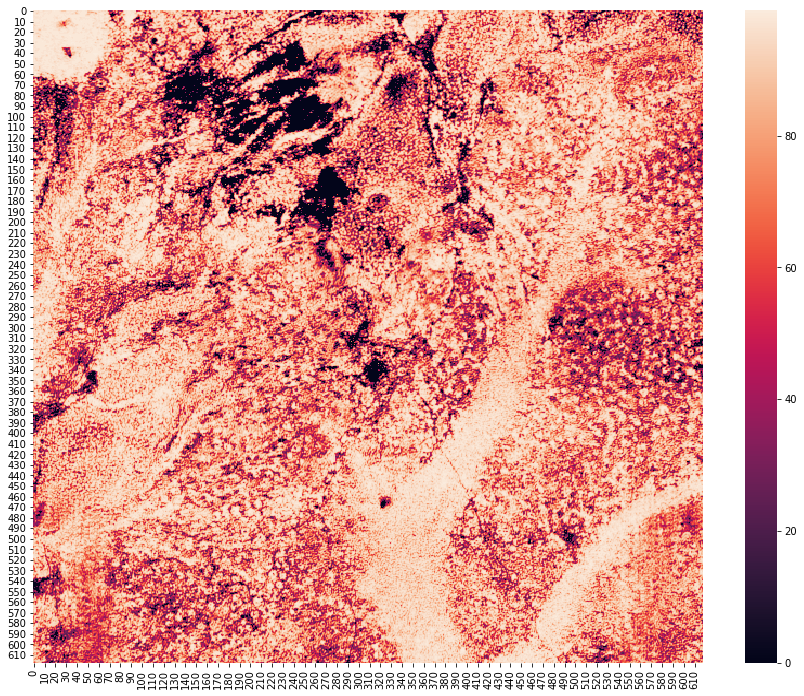

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,12))
x = rasterio.open("../../project-monitoring/tiles/2455/995/2455X995Y_FINAL.tif").read(1)
sns.heatmap(x)

<AxesSubplot:>

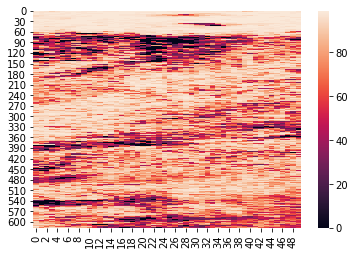

In [7]:
sns.heatmap(x[:, :50])

In [105]:
%run ../../src/tof/tof_downloading.py

ModuleNotFoundError: No module named 'src'

<Figure size 432x288 with 0 Axes>

In [11]:
if os.path.exists("../../config.yaml"):
    with open("../../config.yaml", 'r') as stream:
        key = (yaml.safe_load(stream))
        API_KEY = key['key']
        AWSKEY = key['awskey']
        AWSSECRET = key['awssecret']
    print(f"Successfully loaded key from ../../config.yaml")
    uploader = FileUploader(awskey = AWSKEY, awssecret = AWSSECRET, overwrite = True)
else:
    raise Exception("The API keys do not exist in ../../config.yaml")

Successfully loaded key from ../../config.yaml


In [12]:
local_path = "../../project-monitoring/tiles/"

In [102]:
SIZE = 168
gap_x = 0
gap_y = int(np.ceil((x.shape[1] - SIZE) / 4))
#tiles_folder_x = np.hstack([np.arange(0, x.shape[1] - SIZE, gap_x), np.array(x.shape[1] - SIZE)])
tiles_folder_y = np.hstack([np.arange(0, x.shape[1] - SIZE, gap_y), np.array(x.shape[1] - SIZE)])
tiles_folder_x = [444]

In [162]:
def cartesian(*arrays):
        mesh = np.meshgrid(*arrays)  # standard numpy meshgrid
        dim = len(mesh)  # number of dimensions
        elements = mesh[0].size  # number of elements, any index will do
        flat = np.concatenate(mesh).ravel()  # flatten the whole meshgrid
        reshape = np.reshape(flat, (dim, elements)).T  # reshape and transpose
        return reshape
    

def make_overlapping_windows(tiles: np.ndarray, diff = 7) -> np.ndarray:
    """ Takes the A x B window IDs (n, 4)for an
     X by Y rectangle and enures that the windows are the right
     size (e.g. square, 150 x 150) for running predictions on """
    tiles2 = np.copy(tiles)
    n_x = np.sum(tiles2[:, 0] == 0)
    n_y = np.sum(tiles2[:, 1] == 0)

    tiles2[:n_x, 2] += diff
    tiles2[-n_x:, 2] += diff
    to_adjust = np.full((tiles.shape[0]), diff * 2).astype(np.uint16)
    
    for i in range(len(to_adjust)):
        if (i % n_y == 0) or ((i + 1) % n_y == 0):
            to_adjust[i] -= diff
    tiles2 = tiles2.astype(np.int64)
    tiles2[:, 3] += to_adjust
    tiles2[n_x:-n_x, 2] += (diff * 2)
    tiles2[n_x:, 0] -= diff
    tiles2[:, 1] -= diff
    
    tiles2[tiles2 < 0] = 0.
    return tiles2

windows = cartesian(tiles_folder_x, tiles_folder_y)
win_sizes = np.full_like(windows, SIZE + 7)
tiles_folder = np.hstack([windows, win_sizes])
tiles_folder = np.sort(tiles_folder, axis = 0)
tiles_folder[:, 1] = np.tile(np.unique(tiles_folder[:, 1]), 
    int(len(tiles_folder[:, 1]) / len(np.unique(tiles_folder[:, 1]))))
tiles_array = np.copy(tiles_folder)
tiles_array[1:, 1] -= 7
tiles_array[1:-1, 3] += 7

In [163]:
tiles_folder

array([[444,   0, 175, 175],
       [444, 113, 175, 175],
       [444, 226, 175, 175],
       [444, 339, 175, 175],
       [444, 450, 175, 175]])

In [151]:
tiles_array[:, 0] = 0.

In [176]:
subtile = np.load("../../project-monitoring/tiles/2415/995/processed/113/534.npy")

<AxesSubplot:>

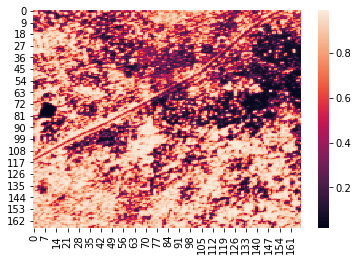

In [177]:
sns.heatmap(subtile)

In [59]:
neighb_date.shape

(10,)

In [40]:
[x for x in tile_date if x in neighb_date]

[16, 21, 31, 56, 60, 75, 130, 340, 345]

In [46]:
to_rm_tile = [idx for idx, date in enumerate(tile_date) if date not in neighb_date]
to_rm_neighb = [idx for idx, date in enumerate(neighb_date) if date not in tile_date]
print(to_rm_tile, to_rm_neighb)

[7, 8, 11] [0]


In [41]:
[x for x in neighb_date if x in tile_date]

[16, 21, 31, 56, 60, 75, 130, 340, 345]

In [ ]:
def align_dates(tile_date, neighb_date):
    to_rm_tile = [idx for idx, date in enumerate(tile_date) if date not in neighb_date]
    to_rm_neighb = [idx for idx, date in enumerate(neighb_date) if date not in tile_date]
    return to_rm_tile, to_rm_neighb

<AxesSubplot:>

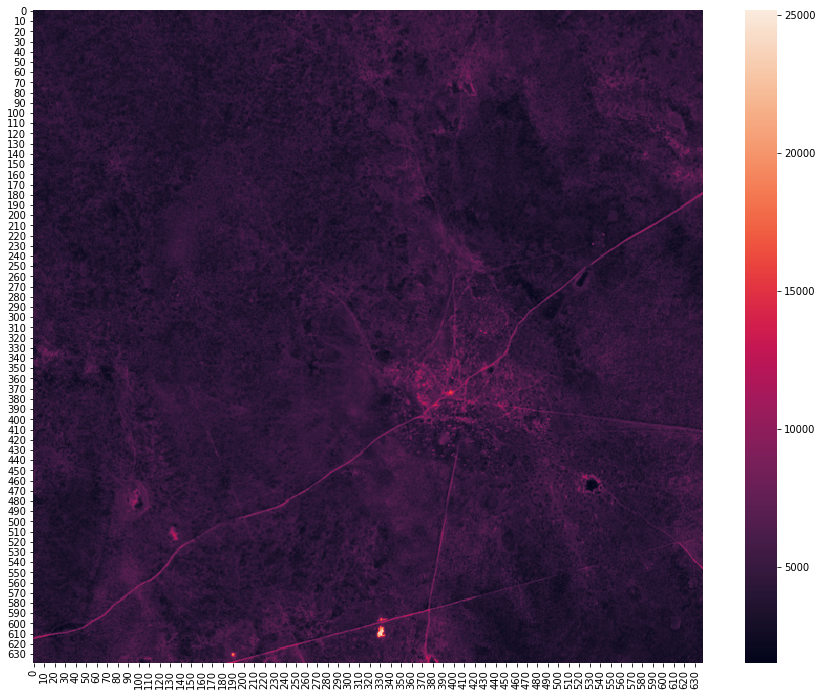

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,12))
y = hkl.load("../../project-monitoring/tiles/2415/995/raw/s2_10/2415X995Y.hkl")
sns.heatmap(y[0, ..., 0])

In [178]:
#### REPRoCESS TIF PART

In [371]:
def load_mosaic_predictions(out_folder: str) -> np.ndarray:
    """
    Loads the .npy subtile files in an output folder and mosaics the overlapping predictions
    to return a single .npy file of tree cover for the 6x6 km tile
    Additionally, applies post-processing threshold rules and implements no-data flag of 255
    
        Parameters:
         out_folder (os.Path): location of the prediction .npy files 
    
        Returns:
         predictions (np.ndarray): 6 x 6 km tree cover data as a uint8 from 0-100 w/ 255 no-data flag
    """
    
    n_border = 0

    right = [x for x in os.listdir(out_folder) if 'right' in x]
    if len(right) > 0:
        n_right = len([x for x in os.listdir(out_folder + right[0]) if '.DS' not in x])
    else:
        n_right = 0
                      
    x_tiles = [x for x in os.listdir(out_folder) if 'right' not in x]
    x_tiles = [int(x) for x in x_tiles if '.DS' not in x]
    max_x = np.max(x_tiles) + SIZE
    for x_tile in x_tiles:
        y_tiles = [y for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        border = [y for y in y_tiles if 'left'  in y]
        n_border += len(border)
        y_tiles = [int(y[:-4]) for y in y_tiles if 'left' not in y]
        
        max_y = np.max(y_tiles) + SIZE
        
    predictions = np.full((max_x, max_y, len(x_tiles) * len(y_tiles) + n_border + n_right), np.nan, dtype = np.float32)
    print(predictions.shape)
    mults = np.full((max_x, max_y, len(x_tiles) * len(y_tiles) + n_border + n_right), 0, dtype = np.float32)
    print(n_border)
    i = 0
    for x_tile in x_tiles:
        y_tiles = [y for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        y_tiles = [int(y[:-4]) for y in y_tiles if 'left' not in y]
        for y_tile in y_tiles:
            output_file = out_folder + str(x_tile) + "/" + str(y_tile) + ".npy"
            if os.path.exists(output_file):
                prediction = np.load(output_file)
                if np.sum(prediction) < SIZE*SIZE*255:
                    prediction = (prediction * 100).T.astype(np.float32)
                    predictions[x_tile: x_tile+SIZE, y_tile:y_tile + SIZE, i] = prediction
                    mults[x_tile: x_tile+SIZE, y_tile:y_tile + SIZE, i] = fspecial_gauss(SIZE, 28)
                i += 1
                
    # LEFT BLOCK
    if n_border > 0:
        for x_tile in x_tiles:
            y_tiles = [y for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
            y_tiles = [int(y[4:-4]) for y in y_tiles if 'left' in y]
            for y_tile in y_tiles:
                output_file = out_folder + str(x_tile) + "/left" + str(y_tile) + ".npy"
                if os.path.exists(output_file):
                    prediction = np.load(output_file)
                    if np.sum(prediction) < SIZE*SIZE*255:
                        prediction = (prediction * 100).T.astype(np.float32)
                        prediction = prediction[84:, :]
                        predictions[x_tile: x_tile+SIZE // 2, y_tile:y_tile + SIZE, i] = prediction
                        mults[x_tile: x_tile+ SIZE // 2, y_tile:y_tile + SIZE, i] = fspecial_gauss(SIZE, 28)[84:, :]
                    i += 1
                    
    # RIGHT BLOCK
    if len(right) > 0:
        for x_tile in right:
            x_tile_name = x_tile
            x_tile = int(x_tile[5:])
            y_tiles = [int(y[:-4]) for y in os.listdir(out_folder + str(x_tile_name) + "/") if '.DS' not in y]
            for y_tile in y_tiles:
                output_file = out_folder + str(x_tile_name) + "/" + str(y_tile) + ".npy"
                print(output_file)
                if os.path.exists(output_file):
                    print(output_file)
                    prediction = np.load(output_file)
                    if np.sum(prediction) < SIZE*SIZE*255:
                        prediction = (prediction * 100).T.astype(np.float32)
                        prediction = prediction[:84, :]
                        print(prediction.shape)
                        predictions[x_tile: x_tile+SIZE // 2, y_tile:y_tile + SIZE, i] = prediction
                        mults[x_tile: x_tile+ SIZE // 2, y_tile:y_tile + SIZE, i] = fspecial_gauss(SIZE, 28)[:84, :]
                    i += 1

    predictions = predictions.astype(np.float32)

    predictions_range = np.nanmax(predictions, axis=-1) - np.nanmin(predictions, axis=-1)
    mean_certain_pred = np.nanmean(predictions[predictions_range < 50])
    mean_uncertain_pred = np.nanmean(predictions[predictions_range > 50])
    
    overpredict = True if (mean_uncertain_pred - mean_certain_pred) > 0 else False
    underpredict = True if not overpredict else False
    
    for i in range(predictions.shape[-1] - n_border - n_right):
        if overpredict:
            problem_tile = True if np.nanmean(predictions[..., i]) > mean_certain_pred else False
        if underpredict:
            problem_tile = True if np.nanmean(predictions[..., i]) < mean_certain_pred else False
        range_i = np.copy(predictions_range)
        range_i[np.isnan(predictions[..., i])] = np.nan
        range_i = range_i[~np.isnan(range_i)]
        if range_i.shape[0] > 0:
            range_i = np.reshape(range_i, (168 // 56, 56, 168 // 56, 56))
            range_i = np.mean(range_i, axis = (1, 3))
            n_outliers = np.sum(range_i > 50)
            if n_outliers >= 2 and problem_tile:
                predictions[..., i] = np.nan
                mults[..., i] = 0.
    
    mults = mults / np.sum(mults, axis = -1)[..., np.newaxis]

    
    predictions[predictions > 100] = np.nan
    out = np.copy(predictions)
    out = np.sum(np.isnan(out), axis = (2))
    n_preds = predictions.shape[-1]
    predictions = np.nansum(predictions * mults, axis = -1)
    predictions[out == n_preds] = np.nan
    predictions[np.isnan(predictions)] = 255.
    predictions = predictions.astype(np.uint8)
                
    original_preds = np.copy(predictions)
    for x_i in range(0, predictions.shape[0] - 3):
        for y_i in range(0, predictions.shape[1] - 3):
            window = original_preds[x_i:x_i+3, y_i:y_i+3]
            if np.max(window) < 35:
                sum_under_35 = np.sum(np.logical_and(window > 10, window < 35))
                if np.logical_and(sum_under_35 > 6, sum_under_35 < 10):
                    window = 0.

            # This removes or mitigates some of the "noisiness" of individual trees
            # Which could have odd shapes depending on where they sit within or between
            # Sentinel pixels 
            if np.max(window) >= 25 and np.argmax(window) == 4:
                window_binary = window >= 25
                if np.sum(window_binary) < 4:
                    if np.sum(window_binary[1]) < 3 and np.sum(window_binary[:, 1]) < 3:
                        window[0, :] = 0
                        window[2, :] = 0
                        window[:, 0] = 0
                        window[:, 2] = 0
                    
    predictions = original_preds 
    predictions[predictions <= .20*100] = 0.        
    #predictions = np.around(predictions / 20, 0) * 20
    predictions[predictions > 100] = 255.
    
    return predictions, mults

In [372]:
def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function

        Parameters:
         size (int): size of square guassian kernel
         sigma (float): diameter of the kernel
    
        Returns:
         g (np.ndarray): gaussian kernel from [0, 1]
    """
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g
preds, mults = load_mosaic_predictions("../../project-monitoring/tiles/2416/995/processed/")

(618, 618, 30)
5


/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in true_divide
/Users/jbrandt.terminal/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in greater


<AxesSubplot:>

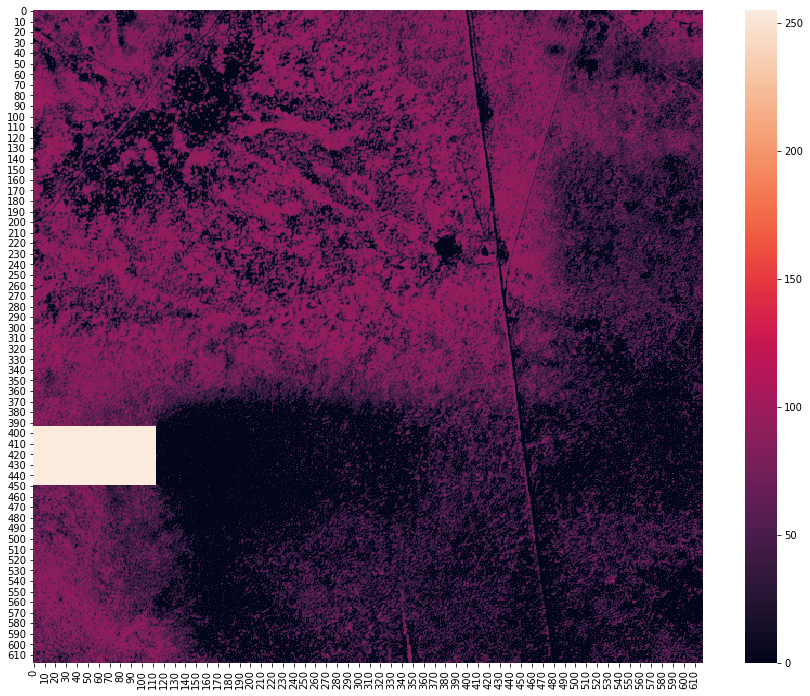

In [373]:
plt.figure(figsize=(15,12))
sns.heatmap(preds)

##### sns.heatmap(preds[])

In [31]:
def recreate_resegmented_tifs(out_folder: str) -> np.ndarray:
    """
    Loads the .npy subtile files in an output folder and mosaics the overlapping predictions
    to return a single .npy file of tree cover for the 6x6 km tile
    Additionally, applies post-processing threshold rules and implements no-data flag of 255
    
        Parameters:
         out_folder (os.Path): location of the prediction .npy files 
    
        Returns:
         predictions (np.ndarray): 6 x 6 km tree cover data as a uint8 from 0-100 w/ 255 no-data flag
    """
    
    n_border = 0

    right = [x for x in os.listdir(out_folder) if 'right' in x]
    if len(right) > 0:
        n_right = len([x for x in os.listdir(out_folder + right[0]) if '.DS' not in x])
    else:
        n_right = 0
                      
    x_tiles = [x for x in os.listdir(out_folder) if 'right' not in x]
    x_tiles = [x for x in x_tiles if '.DS' not in x]
    x_tiles = [x for x in x_tiles if len(os.listdir(out_folder + "/" + x)) > 0]
    x_tiles = [int(x) for x in x_tiles]
    max_x = np.max(x_tiles) + SIZE

    for x_tile in x_tiles:
        y_tiles = [y for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        border = [y for y in y_tiles if 'left'  in y]
        n_border += len(border)
        y_tiles = [int(y[:-4]) for y in y_tiles if 'left' not in y]
        if len(y_tiles) > 1:
            max_y = np.max(y_tiles) + SIZE
        
    n_tiles = len(glob(out_folder + "*/*.npy"))
    predictions = np.full((max_x, max_y, n_tiles), np.nan, dtype = np.float32)
    print(predictions.shape)
    mults = np.full((max_x, max_y, n_tiles), 0, dtype = np.float32)
    i = 0

    for x_tile in x_tiles:
        y_tiles = [y for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
        y_tiles = [int(y[:-4]) for y in y_tiles if 'left' not in y]
        for y_tile in y_tiles:
            output_file = out_folder + str(x_tile) + "/" + str(y_tile) + ".npy"
            print(output_file)
            if os.path.exists(output_file):
                prediction = np.load(output_file)
                if np.sum(prediction) < SIZE*SIZE*255:
                    prediction = (prediction * 100).T.astype(np.float32)
                    predictions[x_tile: x_tile+SIZE, y_tile:y_tile + SIZE, i] = prediction
                    mults[x_tile: x_tile+SIZE, y_tile:y_tile + SIZE, i] = fspecial_gauss(SIZE, 28)
                i += 1
                
    # LEFT BLOCK
    if n_border > 0:
        for x_tile in x_tiles:
            y_tiles = [y for y in os.listdir(out_folder + str(x_tile) + "/") if '.DS' not in y]
            y_tiles = [int(y[4:-4]) for y in y_tiles if 'left' in y]
            for y_tile in y_tiles:
                output_file = out_folder + str(x_tile) + "/left" + str(y_tile) + ".npy"
                if os.path.exists(output_file):
                    prediction = np.load(output_file)
                    if np.sum(prediction) < SIZE*SIZE*255:
                        prediction = (prediction * 100).T.astype(np.float32)
                        prediction = prediction[84:, :]
                        predictions[x_tile: x_tile+SIZE // 2, y_tile:y_tile + SIZE, i] = prediction
                        mults[x_tile: x_tile+ SIZE // 2, y_tile:y_tile + SIZE, i] = fspecial_gauss(SIZE, 35)[84:, :]
                    i += 1
                    
    # RIGHT BLOCK
    if len(right) > 0:
        for x_tile in right:
            x_tile_name = x_tile
            x_tile = int(x_tile[5:])
            y_tiles = [int(y[:-4]) for y in os.listdir(out_folder + str(x_tile_name) + "/") if '.DS' not in y]
            for y_tile in y_tiles:
                output_file = out_folder + str(x_tile_name) + "/" + str(y_tile) + ".npy"
                print(output_file)
                if os.path.exists(output_file):
                    print(output_file)
                    prediction = np.load(output_file)
                    if np.sum(prediction) < SIZE*SIZE*255:
                        prediction = (prediction * 100).T.astype(np.float32)
                        prediction = prediction[:84, :]
                        print(prediction.shape)
                        print(x_tile, y_tile)
                        predictions[x_tile: x_tile+SIZE // 2, y_tile:y_tile + SIZE, i] = prediction
                        mults[x_tile: x_tile+ SIZE // 2, y_tile:y_tile + SIZE, i] = fspecial_gauss(SIZE, 35)[:84, :]
                    i += 1

    predictions = predictions.astype(np.float32)
    """
    predictions_range = np.nanmax(predictions, axis=-1) - np.nanmin(predictions, axis=-1)
    mean_certain_pred = np.nanmean(predictions[predictions_range < 50])
    mean_uncertain_pred = np.nanmean(predictions[predictions_range > 50])
    
    overpredict = True if (mean_uncertain_pred - mean_certain_pred) > 0 else False
    underpredict = True if not overpredict else False
    
    for i in range(predictions.shape[-1] - n_border - n_right):
        if overpredict:
            problem_tile = True if np.nanmean(predictions[..., i]) > mean_certain_pred else False
        if underpredict:
            problem_tile = True if np.nanmean(predictions[..., i]) < mean_certain_pred else False
        range_i = np.copy(predictions_range)
        range_i[np.isnan(predictions[..., i])] = np.nan
        range_i = range_i[~np.isnan(range_i)]
        if range_i.shape[0] > 0:
            range_i = np.reshape(range_i, (168 // 56, 56, 168 // 56, 56))
            range_i = np.mean(range_i, axis = (1, 3))
            n_outliers = np.sum(range_i > 50)
            if n_outliers >= 2 and problem_tile:
                predictions[..., i] = np.nan
                mults[..., i] = 0.
    """
    
    mults = mults / np.sum(mults, axis = -1)[..., np.newaxis]
    """
    predictions[predictions > 100] = np.nan
    out = np.copy(predictions)
    out = np.sum(np.isnan(out), axis = (2))
    n_preds = predictions.shape[-1]
    predictions = np.nansum(predictions * mults, axis = -1)
    predictions[out == n_preds] = np.nan
    predictions[np.isnan(predictions)] = 255.
    predictions = predictions.astype(np.uint8)
                
    original_preds = np.copy(predictions)
    for x_i in range(0, predictions.shape[0] - 3):
        for y_i in range(0, predictions.shape[1] - 3):
            window = original_preds[x_i:x_i+3, y_i:y_i+3]
            if np.max(window) < 35:
                sum_under_35 = np.sum(np.logical_and(window > 10, window < 35))
                if np.logical_and(sum_under_35 > 6, sum_under_35 < 10):
                    window = 0.

            # This removes or mitigates some of the "noisiness" of individual trees
            # Which could have odd shapes depending on where they sit within or between
            # Sentinel pixels 
            if np.max(window) >= 25 and np.argmax(window) == 4:
                window_binary = window >= 25
                if np.sum(window_binary) < 4:
                    if np.sum(window_binary[1]) < 3 and np.sum(window_binary[:, 1]) < 3:
                        window[0, :] = 0
                        window[2, :] = 0
                        window[:, 0] = 0
                        window[:, 2] = 0
                    
    predictions = original_preds 
    predictions[predictions <= .20*100] = 0.        
    predictions[predictions > 100] = 255.
    """
    return predictions, mults

In [32]:
SIZE = 168

def fspecial_gauss(size, sigma):
    """Function to mimic the 'fspecial' gaussian MATLAB function

        Parameters:
         size (int): size of square guassian kernel
         sigma (float): diameter of the kernel
    
        Returns:
         g (np.ndarray): gaussian kernel from [0, 1]
    """
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g

x, y = recreate_resegmented_tifs("../../project-monitoring/tiles/2096/1152/processed/")

(608, 618, 30)
../../project-monitoring/tiles/2096/1152/processed/330/450.npy
../../project-monitoring/tiles/2096/1152/processed/330/226.npy
../../project-monitoring/tiles/2096/1152/processed/330/0.npy
../../project-monitoring/tiles/2096/1152/processed/330/339.npy
../../project-monitoring/tiles/2096/1152/processed/330/113.npy
../../project-monitoring/tiles/2096/1152/processed/440/450.npy
../../project-monitoring/tiles/2096/1152/processed/440/226.npy
../../project-monitoring/tiles/2096/1152/processed/440/0.npy
../../project-monitoring/tiles/2096/1152/processed/440/339.npy
../../project-monitoring/tiles/2096/1152/processed/440/113.npy
../../project-monitoring/tiles/2096/1152/processed/220/450.npy
../../project-monitoring/tiles/2096/1152/processed/220/226.npy
../../project-monitoring/tiles/2096/1152/processed/220/0.npy
../../project-monitoring/tiles/2096/1152/processed/220/339.npy
../../project-monitoring/tiles/2096/1152/processed/220/113.npy
../../project-monitoring/tiles/2096/1152/proce

<AxesSubplot:>

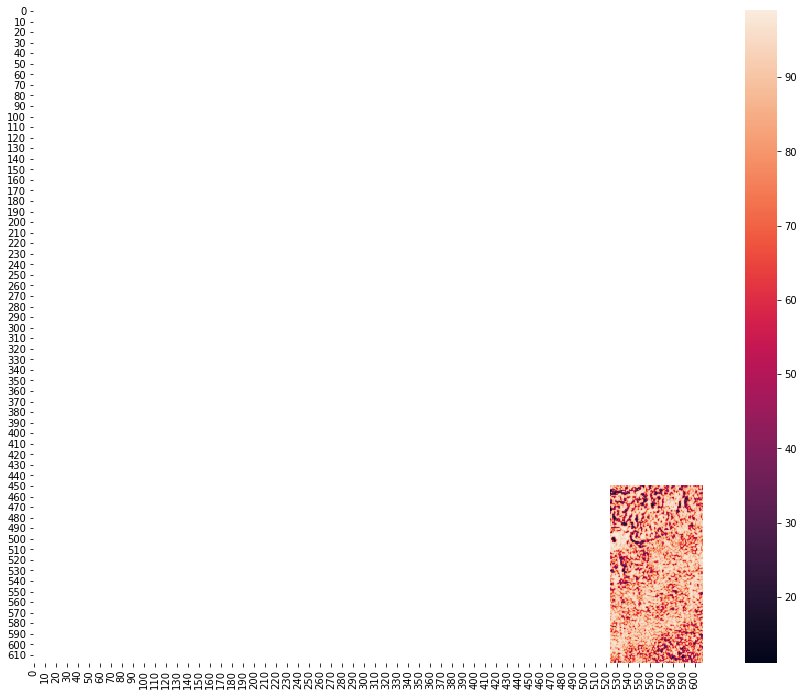

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,12))
sns.heatmap(x[..., -5].T)

<AxesSubplot:>

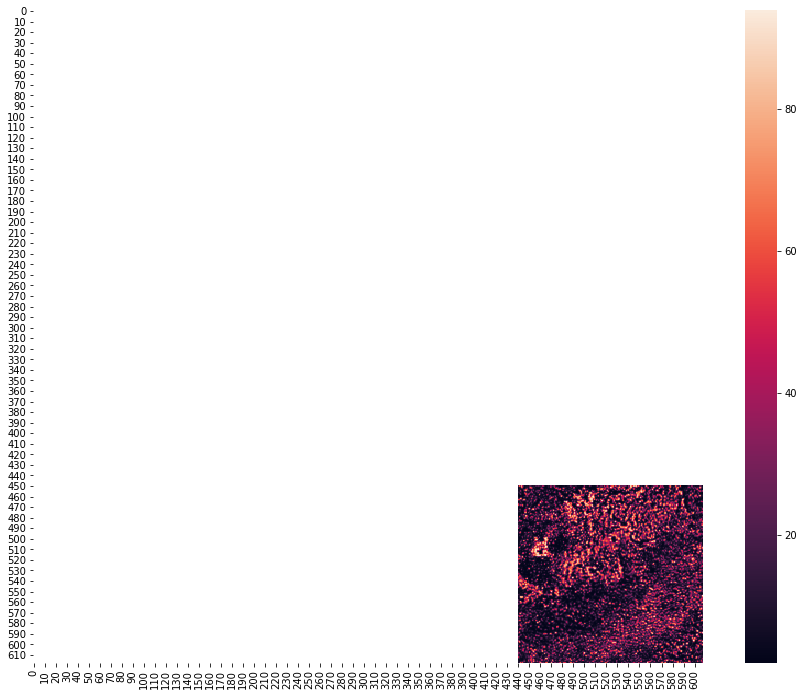

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,12))
sns.heatmap(x[..., -25].T)